<a href="https://colab.research.google.com/github/puckgroen/TM10007_PROJECT/blob/master/group3_final_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Assignment TM10007 - Machine Learning
Group 3
Noor Borren (4450450)
Puck Groen (4470044)
Lucy Knöps (4460421)
Judith Sluijter (4453948)

The script is build up in a way that first, the examination of the two best working methods is worked out. Between the different cells more information is given about the following steps. In the 'Appendices' other methods are shown and choices we made are explained more thoroughly, such as the different preprocessing techniques we used. 

The script is build up as follows: 
- 1. Import packages
- 2. Loading functions
- 3. Load data 
- 4. k-Nearest Neighbour classifier
- 5. Logistic Regression classifier
- Appendix
    - 1.a RFECV
    - 1.b PCA 
    - 1.c Univariate Analysis
    - 2.a Random Forest classifier
    - 2.b Support Vector Machine 


# 1. Import packages

In [3]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
# Import necessary packages and data 
from hn.load_data import load_data

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_auc_score

# 2. Loading functions

In [0]:
# Functions

def data_preprocessing_pca(X_train, X_validation):
    ''' Data preprocessing: first scaling and then PCA with an optimized number of components'''

    # 1. Scaling 
    # Standard scaling performed better on the train-validation set in combination
    # with PCA. 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Principle component analysis
    # Using the cumulative summation of the explained variance, we concluded that in
    # order to retain 95% of the variance 30 components are needed. See the Appendix 
    # for a better visualisation.

    pca = PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca


def data_preprocessing_uni(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    # Robust scaling performed better on the train-validation set in combination
    # with Univariate Analysis and the classifiers.  
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    # 2. Univariate Analysis 
    # A KBest of 10 was found to be working best with this dataset and
    # this combination with the classifiers. The Chi as scoring method
    # could not be used since we had negative numbers after our scaling. 

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    best_features = featureScores.nlargest(10,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni


def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("AUC")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# 3. Data Loading

In [6]:
# Loading of the data 
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = preprocessing.label_binarize(y_labels, ['T12', 'T34']) 
# 0 stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

# Split data in a train and test set. For consistency with our report, the random_state is now fixed. 
# However, we did the analysis with the random_state on. 
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y, stratify=y, test_size=0.2, random_state=0)


The number of samples: 113
The number of features: 159


# Preprocessing of the data
For the preprocessing of the data, we always started with scaling the data. After the scaling we tried different preprocessing steps. First, we tried the Feature ranking with recursive feature elimination, this is shown in Appendix 1.a. This didn't work as well as we wanted to because it gave a large variety of best features between different cross-validations. Therefore, we tried two different preprocessing steps: the Principal Component Analysis (PCA) and the Univariate analysis. These two options for datapreprocessing are shown in the cell with functions (data_preprocessing_pca, data_preprocessing_uni). We applied both of the preprocessing functions to different classifiers and compared the results. 

# Classifiers
After the preprocessing we applied different classifiers were evaluated. We applied the k-Nearest Neighbor classifier (kNN), the Logistic Regression classifier, the Random Forest classifier and the Support Vector Machine classifier. 

# 4. kNN Classifier
First, the kNN classifier will be worked out with the usage of both PCA and Univariate Analysis. An insight will be given in the influence of different values for k-nearest and the classifier will be tuned and validated on the test set. 

As a first approach of coming to a working method, we need to find out if a classifier is too complex for our dataset. For the kNN classifier this meant that we plotted the training and validation AUC to see how these would change when using different values for k. The shuffle mode was set to 'True' because we wanted to obtain a standard deviation for the method. The resulting code can be seen below. 

Text(0.5, 1.0, 'Train and test AUC per k-neighbours for kNN with PCA')

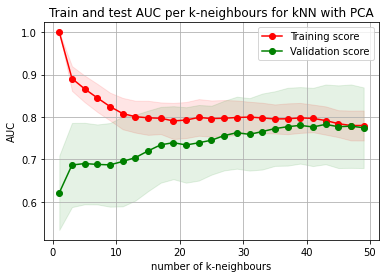

In [7]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation

# AUC of different values for K in kNN
cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_pca)[:, 1]
            validation_proba = clf_knn.predict_proba(X_validation_pca)[:, 1]
            
            score_train = roc_auc_score(y_train, train_proba)
            score_validation = roc_auc_score(y_validation, validation_proba)

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the AUC of different k values (mean scores and the std as shading)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")
ax.legend()
plt.xlabel('number of k-neighbours')
plt.ylabel('AUC')
plt.title('Train and test AUC per k-neighbours for kNN with PCA')

The above curves seem to converge but do have quite a high standard deviation. In addition, for achieving a AUC on the test set of above 0.70, this will probably not be sufficient. To have a better idea about the scoring of the used classifier, we plotted another curve below with the resulting scores. 

Text(0.5, 1.0, 'Train and test score per k-neighbours for kNN with PCA')

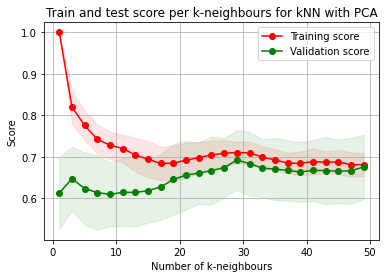

In [8]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation

# Scoring of different values for K in kNN

k_list = list(range(1, 50, 2))
all_train = []
all_validation = []
for _ in range(20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        validation_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

        for k in k_list:
            clf_knn = KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_pca, y_train)

            # Test the classifier on the training data and plot
            score_train = clf_knn.score(X_train_pca, y_train)
            score_validation = clf_knn.score(X_validation_pca, y_validation)            

            train_scores.append(score_train)
            validation_scores.append(score_validation)

        all_train.append(train_scores)
        all_validation.append(validation_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_validation = np.array(all_validation)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

validation_scores_mean = all_validation.mean(axis=0)
validation_scores_std = all_validation.std(axis=0)

# Plot the scoring of different k values (mean scores and the std as shading)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, validation_scores_mean, 'o-', color="g",
        label="Validation score")
ax.legend()
plt.xlabel('Number of k-neighbours')
plt.ylabel('Score')
plt.title('Train and test score per k-neighbours for kNN with PCA')

The above graphics show the trend of the hyperparameter settings for k in kNN. Another method for obtaining the exact number of neighbors which works best in a certain fold is using a GridSearchCV. The use of a GridSearch is shown below. 

In [9]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation
# Use of GridSearchCV to determine k 

clf_knn = KNeighborsClassifier()

parameters = {"n_neighbors": list(range(1, 50, 2))}
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

for _ in range(20):
    X_train_pca, X_validation_pca = data_preprocessing_pca(split_X_train, X_validation)
    grid_search.fit(X_train_pca, split_y_train)
    print(grid_search.best_params_)

{'n_neighbors': 49}
{'n_neighbors': 43}
{'n_neighbors': 43}
{'n_neighbors': 45}
{'n_neighbors': 31}
{'n_neighbors': 33}
{'n_neighbors': 43}
{'n_neighbors': 43}
{'n_neighbors': 29}
{'n_neighbors': 31}
{'n_neighbors': 29}
{'n_neighbors': 39}
{'n_neighbors': 29}
{'n_neighbors': 43}
{'n_neighbors': 49}
{'n_neighbors': 31}
{'n_neighbors': 37}
{'n_neighbors': 41}
{'n_neighbors': 39}
{'n_neighbors': 31}


As you can see in the results above, the optimal number of neighbors varies a lot between folds. In the next section we applied the Gridsearch and evaluated it with the test set. 

In [10]:
# Classifier: kNN
# Preprocessing: PCA
# Dataset: training & validation, test
# Use of GridSearchCV to determine k

parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')


precision_all = []
recall_all = []
test_all = []
for _ in range(20):
    for train_index, test_index in cv_4fold.split(data, y):
        test_scores = []
        precision_scores = []
        recall_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_pca, X_test_pca = data_preprocessing_pca(X_train, X_test)
        grid_search.fit(X_train_pca, y_train) 
        clf_knn = grid_search.best_estimator_

        # Test
        y_pred = clf_knn.predict(X_test_pca)
        precision_score = metrics.precision_score(y_test, y_pred)
        recall_score = metrics.recall_score(y_test, y_pred)

        test_proba = clf_knn.predict_proba(X_test_pca)[:, 1]

        score_test = roc_auc_score(y_test, test_proba)

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)

        test_scores.append(score_test)

    precision_all.append(precision_scores)
    recall_all.append(recall_scores)
    test_all.append(test_scores)


# Create numpy array of scores and calculate the mean and std
all_precision = np.array(precision_all)
all_recall = np.array(recall_all)
all_test = np.array(test_all)

precision_scores_mean = all_precision.mean(axis=0)
precision_scores_std = all_precision.std(axis=0)
recall_scores_mean = all_recall.mean(axis=0)
recall_scores_std = all_recall.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)
print(f'Precision: {str(precision_scores_mean)} +- {str(precision_scores_std)}')
print(f'Recall: {str(recall_scores_mean)} +- {str(recall_scores_std)}')
print(f'AUC: {str(test_scores_mean)} +- {str(test_scores_std)}')


Precision: [0.63660345] +- [0.04056316]
Recall: [0.89642857] +- [0.08593721]
AUC: [0.77002551] +- [0.07456347]


The above results are quite good if we want to achieve an AUC of 70% or higher. However, the AUC varies and there is also a high standard deviation. Therefore, we want to adapt our model to achieve better and more robust results. We will now look at the Univariate Analysis as a preprocessing step. Below, only the train-validation curve is plotted for the AUC.

Text(0.5, 1.0, 'Train and test AUC per k-neighbours for kNN with univariate')

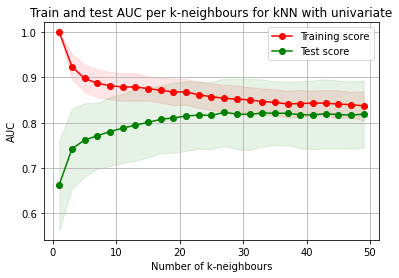

In [11]:
# Classifier: kNN
# Preprocessing: Univariate Analysis
# Dataset: training & validation

# AUC of different values for K in kNN

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)

k_list = list(range(1, 50, 2))
all_train = []
all_test = []
for _ in range(20):
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        # Preprocessing using PCA
        X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_validation)

        for k in k_list:
            clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
            clf_knn.fit(X_train_uni, y_train)

            # Test the classifier on the training data and plot
            train_proba = clf_knn.predict_proba(X_train_uni)[:, 1]
            test_proba = clf_knn.predict_proba(X_validation_uni)[:, 1]
            
            score_train = roc_auc_score(y_train, train_proba)
            score_test = roc_auc_score(y_validation, test_proba)

            train_scores.append(score_train)
            test_scores.append(score_test)

        all_train.append(train_scores)
        all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the AUC of different k values (mean scores and the std as shading)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(k_list, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(k_list, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(k_list, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores_mean, 'o-', color="g",
        label="Test score")
ax.legend()
plt.xlabel('Number of k-neighbours')
plt.ylabel('AUC')
plt.title('Train and test AUC per k-neighbours for kNN with univariate')

The graph above shows a higher AUC with an AUC score above the 0.7, also when taking the standard deviation into account. In addition, it converges more. Next, the hyperparameter tuning using GridSearch is applied and then validated on the test set. 

In [12]:
# Classifier: kNN
# Preprocessing: Univariate Analysis
# Dataset: validation & train, test
# Use of GridSearchCV to determine k

clf_knn = KNeighborsClassifier()

parameters = {"n_neighbors": list(range(1, 50, 2))}

cv_4fold = StratifiedKFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(clf_knn, parameters, cv=cv_4fold, scoring='roc_auc')

precision_all = []
recall_all = []
test_all = []
for _ in range(20):
    for train_index, test_index in cv_4fold.split(data, y):
        precision_scores = []
        recall_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_knn = grid_search.best_estimator_
                
        # Test
        y_pred = clf_knn.predict(X_test_uni)
        precision_score = metrics.precision_score(y_test,y_pred)
        recall_score = metrics.recall_score(y_test,y_pred)

        test_proba = clf_knn.predict_proba(X_test_uni)[:, 1]
        score_test = roc_auc_score(y_test, test_proba)

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        test_scores.append(score_test)

    precision_all.append(precision_scores)
    recall_all.append(recall_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_precision = np.array(precision_all)
all_recall = np.array(recall_all)
all_test = np.array(test_all)

precision_scores_mean = all_precision.mean(axis=0)
precision_scores_std = all_precision.std(axis=0)
recall_scores_mean = all_recall.mean(axis=0)
recall_scores_std = all_recall.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

print(f'Precision: {str(precision_scores_mean)} +- {str(precision_scores_std)}')
print(f'Recall: {str(recall_scores_mean)} +- {str(recall_scores_std)}')
print(f'AUC: {test_scores_mean} +- {test_scores_std}')

Precision: [0.73609865] +- [0.10689712]
Recall: [0.65] +- [0.12757551]
AUC: [0.80880102] +- [0.07484311]


The values of AUC using Univariate Analysis as a preprocessing step are higher than with PCA preprocessing.

# 5. Logistic Regression
Secondly, we will further show the method with the usage of Logistic Regression. Again, with the use of PCA and Univariate Analysis as feature selection techniques. 
Since the Logistic Regression has different hyperparameters, we used learning curves to have a better insight in the influence of hyperparameters on the performance in the train-validation set. Shuffle was to set to 'False', because we wanted to obtain the same graph with every run. When applied on the test set, the shuffle mode was set to 'True' in order to obtain standard deviations.

Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for PCA preprocessing: 0.8050964187327824


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

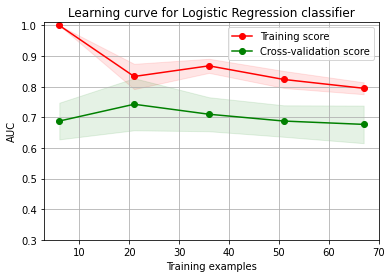

In [13]:
# Classifier: Logistic Regression
# Preprocessing: PCA
# Dataset: train & validation 
# Use of GridsearchCV for parameter tuning

# Set up the GridSearch with a set of parameters
cv_4fold = StratifiedKFold(n_splits=4, shuffle=False)

grid_param = {'penalty' : ['l1', 'l2'], 'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid=grid_param, cv=cv_4fold,n_jobs=-1,scoring='roc_auc') 

X_train_pca, _ = data_preprocessing_pca(split_X_train, split_X_test)
grid_search.fit(X_train_pca, split_y_train)

# Show the complete results of the cross validation
pd.DataFrame(grid_search.cv_results_)
print(f'Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for PCA preprocessing: {grid_search.best_score_}')

title = 'Learning curve for Logistic Regression classifier'
fig = plt.figure()
ax = fig.add_subplot(111)
plot_learning_curve(grid_search.best_estimator_, title, X_train_pca, split_y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)

When using PCA in the preprocessing method, a lot of variance can still be seen from the learning curve, both in the graph as when we run it multiple times. 

To generalize better, we tried the Univariate Analysis below in a same fashion.

Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for Univariate preprocessing: 0.8631198347107437


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

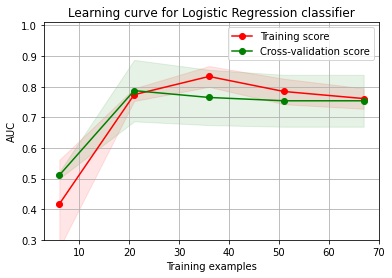

In [14]:
# Classifier: Logistic Regression
# Preprocessing: Univariate Analysis
# Dataset: train & validation 
# Use of GridsearchCV for parameter tuning

# Set up the GridSearch with a set of parameters
cv_4fold = StratifiedKFold(n_splits=4, shuffle=False)

grid_param = {'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(), param_grid=grid_param, cv=cv_4fold,n_jobs=-1,scoring='roc_auc') 

# Data preprocessing 
X_train_uni, _ = data_preprocessing_uni(split_X_train, split_y_train, split_X_test)
grid_search.fit(X_train_uni, split_y_train)

# Show the complete results of the cross validation
pd.DataFrame(grid_search.cv_results_)
print(f'Best GridSearchCV of Logistic Regression within the 4-fold cross-validation for Univariate preprocessing: {grid_search.best_score_}')

title = 'Learning curve for Logistic Regression classifier'
fig = plt.figure()
ax = fig.add_subplot(111)
plot_learning_curve(grid_search.best_estimator_, title, X_train_uni, split_y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)

The use of Univariate Analysis seems to improve the AUC score. This can both be seen in the attribute of GridSearchCV.best_score_ as can be seen in the learning curve graph where the training and validation error are nearer to each other within the sample size that we have. Next, we apply the Logistic Regression using Univariate Analysis on the test data.

In [15]:
# Classifier: Logistic Regression
# Preprocessing: Univariate Analysis
# Dataset: train & validation, test
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_param = {'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(),param_grid=grid_param, cv=cv_4fold,n_jobs=-1, scoring='roc_auc') 

precision_all = []
recall_all = []
test_all = []
for _ in range(20):
    for train_index, test_index in cv_4fold.split(data, y):
        precision_scores = []
        recall_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_lr = grid_search.best_estimator_
        
        # Test
        y_pred = clf_lr.predict(X_test_uni)
        precision_score = metrics.precision_score(y_test,y_pred)
        recall_score=metrics.recall_score(y_test,y_pred)

        test_proba = clf_lr.predict_proba(X_test_uni)[:, 1]

        score_test = metrics.roc_auc_score(y_test, test_proba)

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        test_scores.append(score_test)

    precision_all.append(precision_scores)
    recall_all.append(recall_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_precision = np.array(precision_all)
all_recall = np.array(recall_all)
all_test = np.array(test_all)

precision_scores_mean = all_precision.mean(axis=0)
precision_scores_std = all_precision.std(axis=0)
recall_scores_mean = all_recall.mean(axis=0)
recall_scores_std = all_recall.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

print(f'Precision: {str(precision_scores_mean)} +- {str(precision_scores_std)}')
print(f'Recall: {str(recall_scores_mean)} +- {str(recall_scores_std)}')
print(f'The resulting method gives an AUC of {test_scores_mean} +- {test_scores_std}')

Precision: [0.74320005] +- [0.08287705]
Recall: [0.77142857] +- [0.10497813]
The resulting method gives an AUC of [0.84617347] +- [0.06163289]


# Appendix
1. Preprocessing
2. Classifiers

 # 1.a Recursive feature elimination

 Our first idea was to apply the recursive feature elimination (RFE) method with a linear SVM. Then, the optimal number of features would be the input for the number of components for the PCA. Unfortunally, a large variance was present in this method per fold, indicating this method is not robust for our dataset. The optimal number of features varied wildly per fold, from 1 to approximately 140. We tried different scaling methods, different classifiers in the RFE. This did not reduce the variance of the RFE method. A 4-fold cross-validation is showed below for ilustration. 
Therefore, we focussed on other the preprocessing methods PCA and univariate analysis.

 

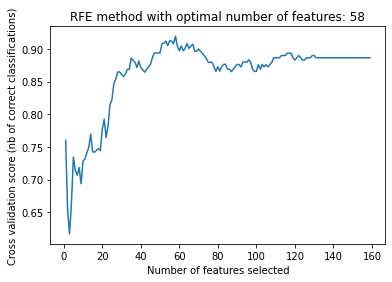

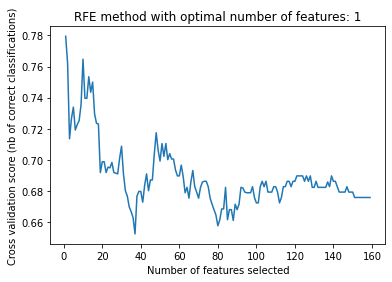

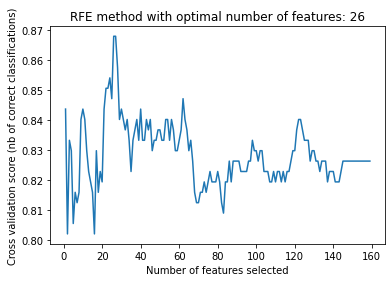

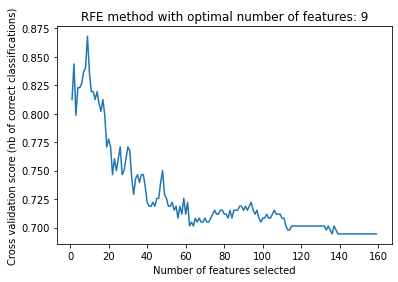

In [16]:
def data_preprocessing(X_train, y_train):
    '''Data preprocessing: Scaling, RFECV, PCA'''

    # 1. Scaling
    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    # 2. Feature selection/extraction
    # Create the Recursive Feature Elimination object and compute a cross-validated score.
    svc = svm.SVC(kernel="linear")

    rfecv = feature_selection.RFECV(estimator=svc, step=1, cv=model_selection.StratifiedKFold(4), scoring='roc_auc')
    rfecv.fit(X_train_scaled, y_train)

    # Plot number of features VS. cross-validation scores
    fig = plt.figure()
    plt.title('RFE method with optimal number of features: %d' % rfecv.n_features_)
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plot = plt.show()

    # 3. PCA
    n_selected_features = rfecv.n_features_
    n_samples = len(X_train.index)
    n_components_rfe = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components_rfe)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)

    return X_train_pca, plot

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)
for training_index, _ in cv_4fold.split(split_X_train, split_y_train):
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    X_train_pca, plot = data_preprocessing(X_train, y_train)

# 1.b PCA
To determine the number of components for PCA we used the Cumulative Summation of the Explained Variance. To retain 95% of the variance, 30 components are needed.

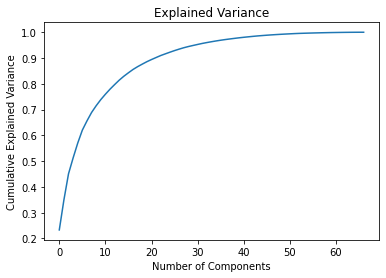

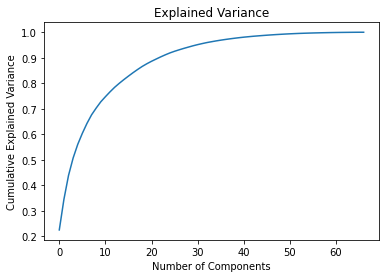

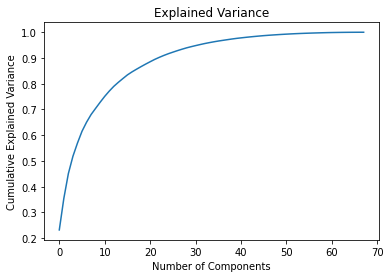

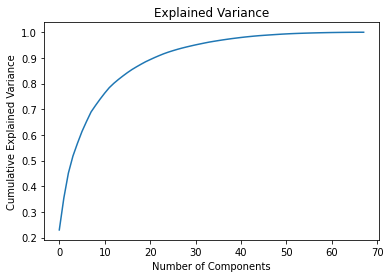

In [17]:
# Determining number of components for PCA

# Loop over the folds
for training_index, _ in cv_4fold.split(split_X_train, split_y_train):
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Scale data
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)

    #PCA
    pca = PCA().fit(X_train_scaled)

    # Plotting the Cumulative Summation of the Explained Variance in a 4-fold cross-validation
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance')
    plt.show()

 # 1.c Univariate Analysis

1.c.1:
The aim of the feature importance ranking is to evaluate the optimal number of features as input for the univariate analysis. We expected to see a cut-off value in feature importance after a certain number of features. The feature importances were plotted with the random forest method. Unfortunally, no clear cut-off value was seen in the number of features. Therefore, values between 5 and 70 were initially tried manually to see what worked best.   

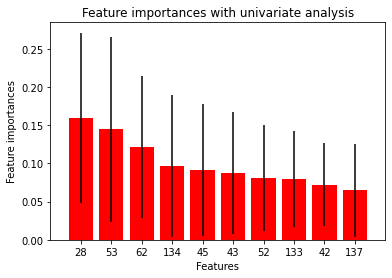

In [18]:
def data_preprocessing_uni_feature_importance(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)
    # change the number of k for tuning.
    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
    best_features = featureScores.nlargest(10,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    # 2.1 Feature importance ranking with random forest
    # 2.1.1 Build a forest and compute the feature importances
    forest = ExtraTreesClassifier(n_estimators=300,
                                  random_state=0)

    forest.fit(X_train_uni, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # 2.1.2 Plot the feature importances of the forest with corresponding labels
    plt.figure()
    plt.title("Feature importances with univariate analysis")
    plt.xlabel('Features')
    plt.ylabel('Feature importances')
    plt.bar(range(X_train_uni.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train_uni.shape[1]), X_train_uni.columns)
    plt.xlim([-1, X_train_uni.shape[1]])
    plot = plt.show()

    return X_train_uni, X_validation_uni, plot

X_train_uni, X_validation_uni, plot = data_preprocessing_uni_feature_importance(X_train, y_train, X_validation)


1.c.2:
The aim of this part is to evaluate if the same features are selected using different folds. Running the model multiple times, roughly the same features are returned in every fold. This means certain features are informative and therefore almost every fold selected with the Univariate Analysis.

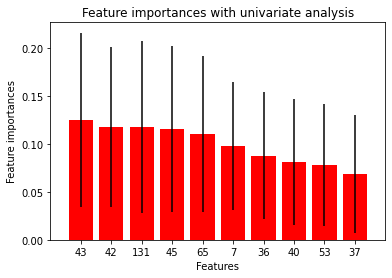

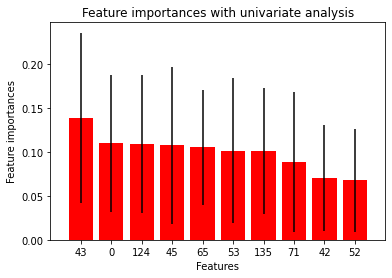

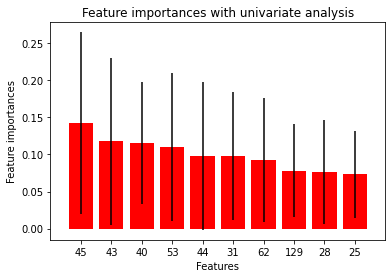

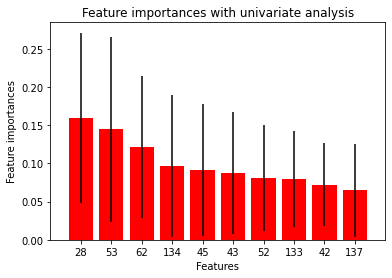

In [19]:
labels = []
cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)
for training_index, _ in cv_4fold.split(split_X_train, split_y_train):
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    forest = ExtraTreesClassifier(n_estimators=300,
                                      random_state=0)

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)
    # change the number of k for tuning.
    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
    best_features = featureScores.nlargest(10,'Score')['Specs']
    X_train_uni = df_X_train_scaled[best_features]

    forest.fit(X_train_uni, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                  axis=0)
    indices = np.argsort(importances)[::-1]

    # 2.1.2 Plot the feature importances of the forest with corresponding labels
    plt.figure()
    plt.title("Feature importances with univariate analysis")
    plt.xlabel('Features')
    plt.ylabel('Feature importances')
    plt.bar(range(X_train_uni.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train_uni.shape[1]), X_train_uni.columns)
    plt.xlim([-1, X_train_uni.shape[1]])
    plot = plt.show()

    labels.append(X_train_uni.columns)

# 2.a Random Forest Classifier
Another classifier we computed was Random Forest Classifier (RF). 
The code below shows the set-up for the RF classifier. First, the RF classifier with a PCA preprocessing is applied. Despite tuning of the hyperparameters of the RF, a lot of variance was present in the accuracy. Then, we performed the RF classifier with the Univariate Analysis as a preprocessing step. A note here is that the best k features was set to 20 because it seemed to converge slightly better. This resulted in a slightly higher mean accuracy, but still with a large variance. We concluded that the random forest classifier is not the optimal choice for our dataset. The model is too complex for our dataset.

In [0]:
# Data preprocessing function for Random Forest classifier
def data_preprocessing_uni_rf(X_train, y_train, X_validation):
    '''Data preprocessing: first scaling and then univariate analysis'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(mutual_info_classif, k=20)
    fit = bestfeatures.fit(df_X_train_scaled, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  # Naming the dataframe columns
    best_features = featureScores.nlargest(20,'Score')['Specs']

    X_train_uni = df_X_train_scaled[best_features]
    X_validation_uni = df_X_validation_scaled[best_features]

    return X_train_uni, X_validation_uni

An insight is given in the hyperparameter tuning of the RF. Besides printing the best results per fold, a learning curve is also plotted. 

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.2s finished


Best number of trees: 100
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.6521739130434783
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.1s finished


Best number of trees: 50
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.6956521739130435
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.1s finished


Best number of trees: 400
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.7272727272727273
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.1s finished


Best number of trees: 200
Best split quality function: entropy
Best bootstrap: False
Accuracy: 0.7272727272727273
--------------------------------------------------------------------------------


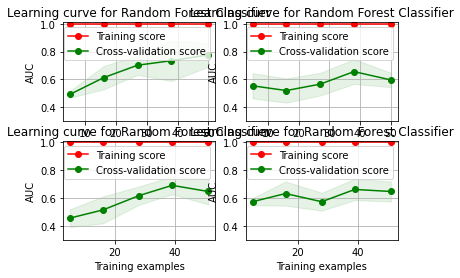

In [27]:
# Classifier: Random Forest
# Preprocessing: PCA
# Dataset: train & validation
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Preprocessing
    X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

    # Random Forest Classification
    # k = 4
    # skf = StratifiedKFold(k, random_state=None)

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid_param, scoring='roc_auc', cv=cv_4fold, n_jobs=-1, verbose=2) 
    grid_search.fit(X_train_pca, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(f'Best number of trees: {(n_estimators)}')
    print(f'Best split quality function: {(criterion)}')
    print(f'Best bootstrap: {(bootstrap)}')
    best_result = grid_search.best_score_

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(X_train_pca, y_train)

    # Calculate accuracy
    classifier_predictions_test = classifier.predict(X_validation_pca)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(f'Accuracy: {(accuracy)}')
    print('-'*80)

    # Learning curve
    title = 'Learning curve for Random Forest Classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(classifier, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)
    num += 1

One can see in the results above, the accuracy is varying a lot between the folds. It can differ from approximately 0.55 to 0.80. It can be concluded that the random forest method with PCA preprocessing is not robust for this dataset. In addition, it does not seem to converge which could mean that the model is too complex for our dataset. 

In the section below, the RF classifier with Univariate Analysis as preprocessing is conducted.

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.0s finished


Best number of trees: 10
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.6956521739130435
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.0s finished


Best number of trees: 100
Best split quality function: entropy
Best bootstrap: True
Accuracy: 0.8260869565217391
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.0s finished


Best number of trees: 400
Best split quality function: gini
Best bootstrap: True
Accuracy: 0.6818181818181818
--------------------------------------------------------------------------------
Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.9s finished


Best number of trees: 50
Best split quality function: entropy
Best bootstrap: True
Accuracy: 0.5909090909090909
--------------------------------------------------------------------------------


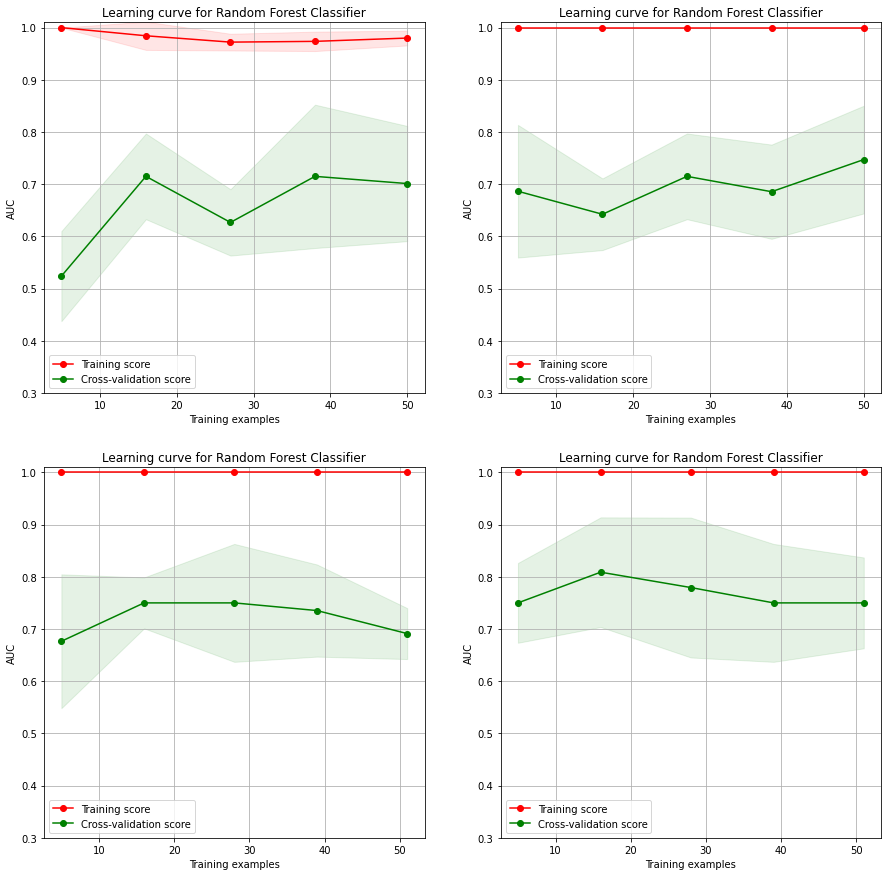

In [22]:
# Classifier: Random Forest
# Preprocessing: Univariate Analysis
# Dataset: train & validation
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    train_scores = []
    test_scores = []
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]

    # Preprocessing
    X_train_uni, X_validation_uni = data_preprocessing_uni_rf(X_train, y_train, X_validation)

    # Random Forest Classification
    k = 4
    skf = StratifiedKFold(k, random_state=None) 

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid_param, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=2)   
    grid_search.fit(X_train_uni, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(f'Best number of trees: {(n_estimators)}')
    print(f'Best split quality function: {(criterion)}')
    print(f'Best bootstrap: {(bootstrap)}')

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(X_train_uni, y_train)

    # Calculate accuracy
    classifier_predictions_test = classifier.predict(X_validation_uni)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(f'Accuracy: {(accuracy)}')
    print('-'*80)

    # Learning curve
    title = 'Learning curve for Random Forest Classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(classifier, title, X_train_uni, y_train, ax, ylim=(0.3, 1.01), cv=skf)
    num += 1

Just to be complete, we will show how the last method works on our test set. 

In [23]:
# Classifier: Random Forest Classifier
# Preprocessing: Univariate Analysis
# Dataset: train & validation, test
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)
grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=grid_param, scoring='roc_auc', cv=cv_4fold, n_jobs=-1)

precision_all = []
recall_all = []
test_all = []
for _ in range(4):
    for train_index, test_index in cv_4fold.split(data, y):
        precision_scores = []
        recall_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_lr = grid_search.best_estimator_
        
        # Test
        y_pred = clf_lr.predict(X_test_uni)
        precision_score = metrics.precision_score(y_test,y_pred)
        recall_score=metrics.recall_score(y_test,y_pred)

        test_proba = clf_lr.predict_proba(X_test_uni)[:, 1]

        score_test = metrics.roc_auc_score(y_test, test_proba)

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        test_scores.append(score_test)

    precision_all.append(precision_scores)
    recall_all.append(recall_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_precision = np.array(precision_all)
all_recall = np.array(recall_all)
all_test = np.array(test_all)

precision_scores_mean = all_precision.mean(axis=0)
precision_scores_std = all_precision.std(axis=0)
recall_scores_mean = all_recall.mean(axis=0)
recall_scores_std = all_recall.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

print(f'Precision: {str(precision_scores_mean)} +- {str(precision_scores_std)}')
print(f'Recall: {str(recall_scores_mean)} +- {str(recall_scores_std)}')
print(f'The resulting method gives an AUC of {test_scores_mean} +- {test_scores_std}')

Precision: [0.57529762] +- [0.03263919]
Recall: [0.60714286] +- [0.06185896]
The resulting method gives an AUC of [0.7002551] +- [0.03564589]


As one can see in the results above, the accuracy is varying a lot. Random Forest with PCA as preprocessing results in a lower mean accuracy than Random Forest with Univariate Analysis as preprocessing. 

The overall conclusion is that this Random Forest classifier is not suitable for out dataset.

# 2.b Support Vector Machine (SVM)
Lastly, the SVM was used as a classifier. Again with the PCA and Univariate Analysis preprocessing techniques. The Univariate Analysis outpeformed the PCA, however still the results were not that consistent throughout different runs. Again, GridSearchCV was used for hyperparameter optimalisation. In the first two cells, one can see what different hyperparameter settings were optimal for the specific folds.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


rbf
0.001
10
Accuracy: 0.6521739130434783
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


rbf
0.01
1
Accuracy: 0.6956521739130435
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 315 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


rbf
0.01
10
Accuracy: 0.6818181818181818
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.6s finished


rbf
0.001
10
Accuracy: 0.6818181818181818
--------------------------------------------------------------------------------


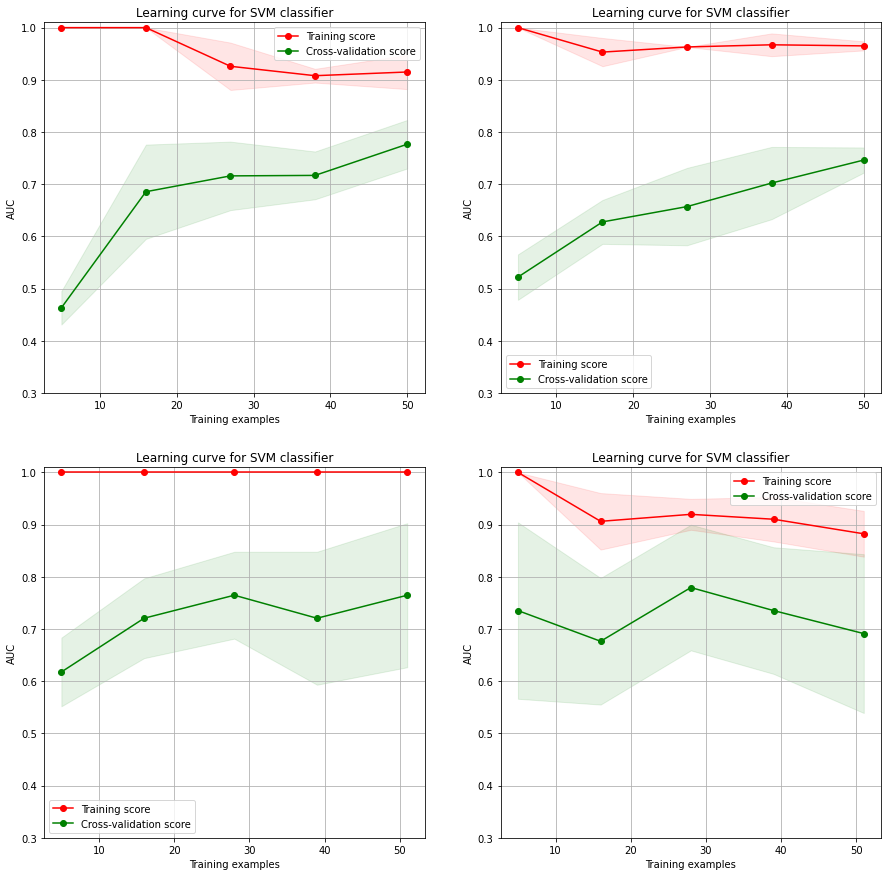

In [24]:
# Classifier: SVM
# Preprocessing: PCA
# Dataset: train & validation
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=False)

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Preprocessing
    X_train_pca, X_validation_pca = data_preprocessing_pca(X_train, X_validation)

    # Hyperparameter tuning
    grid_param =[{'kernel': ('linear','rbf'), 'gamma': [1e-04, 1e-03, 1e-02, 0.1, 1, 10],'C': [1e-04, 1e-03, 1e-02, 0.1, 1, 10]}]
    grid_search=GridSearchCV(SVC(),grid_param,n_jobs=-1,verbose=2)
    grid_search.fit(X_train_pca, y_train)

    best_hyperparameters = grid_search.best_params_

    kernel=best_hyperparameters.get('kernel')
    gamma=best_hyperparameters.get('gamma')
    C=best_hyperparameters.get('C')

    print(kernel)
    print(gamma)
    print(C)
    best_result = grid_search.best_score_  

    # Classification with tuned hyperparameters
    clf_svm = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    clf_svm.fit(X_train_pca, y_train)

    # Calculate accuracy
    clf_svm_predictions = clf_svm.predict(X_validation_pca)

    accuracy = metrics.accuracy_score(y_validation, clf_svm_predictions)
    print(f'Accuracy: {(accuracy)}')
    print('-'*80)

    # Learning curve
    title = 'Learning curve for SVM classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(clf_svm, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)
    num += 1

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    1.0s finished


linear
0.0001
1
Accuracy: 0.7391304347826086
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    1.1s finished


linear
0.0001
0.1
Accuracy: 0.782608695652174
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    1.1s finished


rbf
0.001
10
Accuracy: 0.6818181818181818
--------------------------------------------------------------------------------
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    1.0s finished


linear
0.0001
0.1
Accuracy: 0.6363636363636364
--------------------------------------------------------------------------------


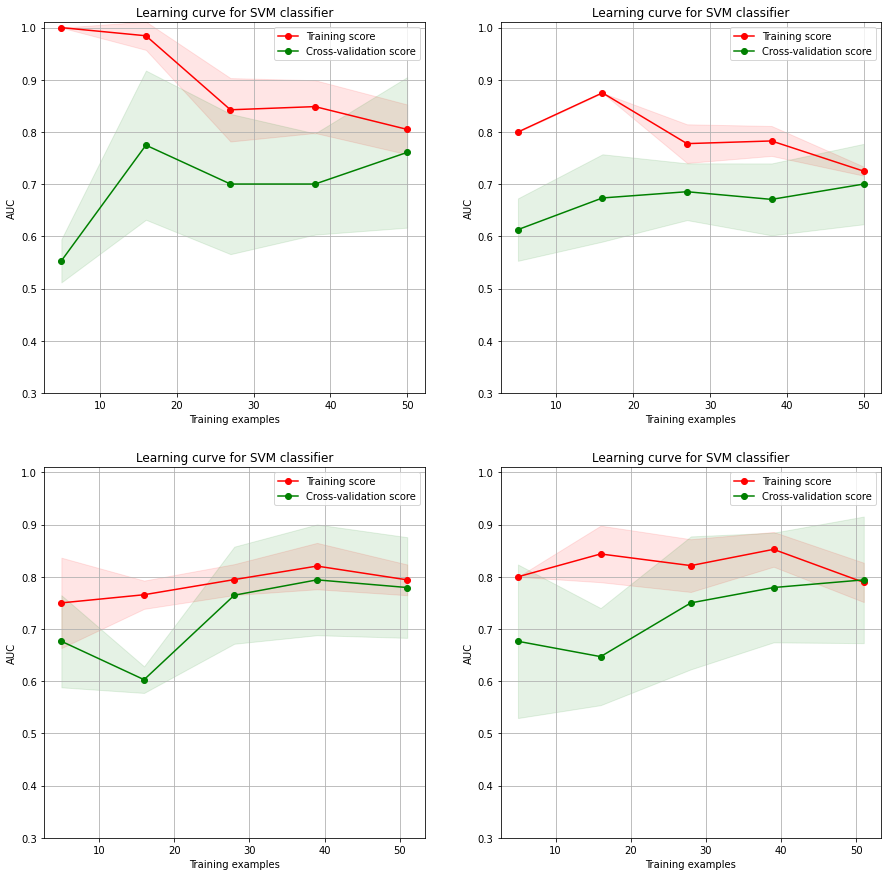

In [25]:
# Classifier: SVM
# Preprocessing: Univariate Analysis
# Dataset: train & validation
# Use of GridsearchCV for parameter tuning

# Loop over the folds
num = 0
fig = plt.figure(figsize=(15, 15))
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    # Preprocessing
    X_train_uni, X_validation_uni = data_preprocessing_uni(X_train, y_train, X_validation)

    # Hyperparameter tuning
    grid_param =[{'kernel': ('linear','rbf'), 'gamma': [1e-04, 1e-03, 1e-02, 0.1, 1, 10],'C': [1e-04, 1e-03, 1e-02, 0.1, 1, 10]}]
    grid_search=GridSearchCV(SVC(),grid_param,n_jobs=-1,verbose=2)
    grid_search.fit(X_train_uni, y_train)

    best_hyperparameters = grid_search.best_params_

    kernel=best_hyperparameters.get('kernel')
    gamma=best_hyperparameters.get('gamma')
    C=best_hyperparameters.get('C')

    print(kernel)
    print(gamma)
    print(C)
    best_result = grid_search.best_score_  

    # Classification with tuned hyperparameters
    clf_svm = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    clf_svm.fit(X_train_uni, y_train)

    # Calculate accuracy
    clf_svm_predictions = clf_svm.predict(X_validation_uni)

    accuracy = metrics.accuracy_score(y_validation, clf_svm_predictions)
    print(f'Accuracy: {(accuracy)}')
    print('-'*80)

    # Learning curve
    title = 'Learning curve for SVM classifier'
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(clf_svm, title, X_train_uni, y_train, ax, ylim=(0.3, 1.01), cv=cv_4fold)
    num+=1

As can be seen in the cell below, the SVM model works moderately well on the test set. 

In [26]:
# Classifier: SVM
# Preprocessing: Univariate Analysis
# Dataset: train & validation, test
# Use of GridsearchCV for parameter tuning

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
grid_param =[{'kernel': ('linear','rbf'), 'gamma': [1e-04, 1e-03, 1e-02, 0.1, 1, 10],'C': [1e-04, 1e-03, 1e-02, 0.1, 1, 10]}]
grid_search = GridSearchCV(SVC(),param_grid=grid_param, cv=cv_4fold,n_jobs=-1, scoring=None) 

precision_all = []
recall_all = []
test_all = []
for _ in range(20):
    for train_index, test_index in cv_4fold.split(data, y):
        precision_scores = []
        recall_scores = []
        test_scores = []
        X_test = data.iloc[test_index]
        y_test = y[test_index]
        X_train = data.iloc[train_index]
        y_train = y[train_index]

        # Data preprocessing
        X_train_uni, X_test_uni = data_preprocessing_uni(X_train, y_train, X_test)

        grid_search.fit(X_train_uni, y_train) 
        clf_svm = grid_search.best_estimator_
        
        # Test
        y_pred = clf_svm.predict(X_test_uni)
        if hasattr(clf_svm, 'predict_proba'):
            y_score = clf.predict_proba(X1)[:, 1]
        else:
            y_score = y_pred
        
        precision_score = metrics.precision_score(y_test,y_score)
        recall_score=metrics.recall_score(y_test,y_score)        
        score_test = metrics.roc_auc_score(y_test, y_score)

        precision_scores.append(precision_score)
        recall_scores.append(recall_score)
        test_scores.append(score_test)

    precision_all.append(precision_scores)
    recall_all.append(recall_scores)
    test_all.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_precision = np.array(precision_all)
all_recall = np.array(recall_all)
all_test = np.array(test_all)

precision_scores_mean = all_precision.mean(axis=0)
precision_scores_std = all_precision.std(axis=0)
recall_scores_mean = all_recall.mean(axis=0)
recall_scores_std = all_recall.std(axis=0)
test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

print(f'Precision: {str(precision_scores_mean)} +- {str(precision_scores_std)}')
print(f'Recall: {str(recall_scores_mean)} +- {str(recall_scores_std)}')
print(f'The resulting method gives an AUC of {test_scores_mean} +- {test_scores_std}')

Precision: [0.79796434] +- [0.10730974]
Recall: [0.68214286] +- [0.13827472]
The resulting method gives an AUC of [0.74285714] +- [0.05714286]


The SVM varies a lot and the validation-test curves show that there might not be enough data for this classifier. 